In [1]:
import numpy as np
import torch.nn as nn
import torch
import math
import matplotlib.pyplot as plt
import cv2
import csv
import tensorflow as tf
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import sys

In [2]:
img_path = 'test_image\L.jpeg'

test_img = cv2.imread(img_path, cv2.IMREAD_COLOR)

cv2.imshow('loaded image', test_img)

cv2.waitKey(0)

cv2.destroyAllWindows()

In [3]:
print(test_img.shape)
print(test_img.dtype)
print(test_img.data)
print(test_img.astype)

(400, 400, 3)
uint8
<built-in method astype of numpy.ndarray object at 0x000002B926E75590>


In [4]:
print(test_img[:1])

test_img_tensor = torch.tensor(test_img)
print(test_img_tensor[:1])

test_img_tensor = test_img_tensor / 255
print(test_img_tensor[:1])

to_tensor = transforms.ToTensor()
test_img_tensor2 = to_tensor(test_img)
print(test_img_tensor2.T[:1])
print(test_img_tensor2.permute(1,2,0)[:1])


[[[ 77 105 112]
  [ 80 108 115]
  [ 86 112 118]
  ...
  [ 25  24  26]
  [ 26  25  27]
  [ 27  26  28]]]
tensor([[[ 77, 105, 112],
         [ 80, 108, 115],
         [ 86, 112, 118],
         ...,
         [ 25,  24,  26],
         [ 26,  25,  27],
         [ 27,  26,  28]]], dtype=torch.uint8)
tensor([[[0.3020, 0.4118, 0.4392],
         [0.3137, 0.4235, 0.4510],
         [0.3373, 0.4392, 0.4627],
         ...,
         [0.0980, 0.0941, 0.1020],
         [0.1020, 0.0980, 0.1059],
         [0.1059, 0.1020, 0.1098]]])
tensor([[[0.3020, 0.4118, 0.4392],
         [0.3216, 0.4314, 0.4588],
         [0.3451, 0.4549, 0.4824],
         ...,
         [0.6667, 0.7686, 0.8235],
         [0.6627, 0.7686, 0.8235],
         [0.6627, 0.7686, 0.8235]]])
tensor([[[0.3020, 0.4118, 0.4392],
         [0.3137, 0.4235, 0.4510],
         [0.3373, 0.4392, 0.4627],
         ...,
         [0.0980, 0.0941, 0.1020],
         [0.1020, 0.0980, 0.1059],
         [0.1059, 0.1020, 0.1098]]])


C:\Users\zkdls\AppData\Local\Temp\ipykernel_15116\2547755168.py:11: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3729.)
  print(test_img_tensor2.T[:1])


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

1. 이미지를 cv2.imread(path, cv2.imread_color) 등을 통해 읽으면 nd.array 형태로 저장됨.
2. ToTensor는 PIL 또는 ndarray를 C * H * W 형태로 치환하고 255로 나눠 정규화해줌.
3. pytorch에서 blabla.T 처럼 전치하는 것은 위험함. .T는 마지막 두차원만 전치시켜줌.
    예를 들어 (C, H, W) 형태의 텐서를 .T하면 (C, W, H)가 됨. 즉 원하는 차원변경이 아닐 수 있다.
    따라서, .permute(*dims) 함수를 사용해 전치시키는 습관이 필요하다.


In [6]:
download_path = 'test_image'

trainset= torchvision.datasets.CIFAR10(root=download_path, train=True,
                                      download=True, transform = transform)

testset= torchvision.datasets.CIFAR10(root=download_path, train=False,
                                      download=True, transform = transform)


100.0%


In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [8]:
print(trainset[0][0].shape)

torch.Size([3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


airplane dog   automobile airplane


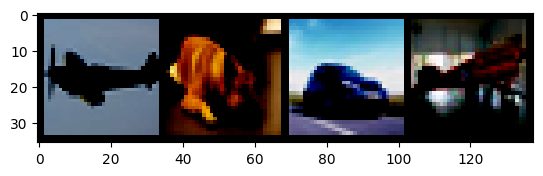

In [9]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images) # 역정규화
npimg = img_grid.numpy() # matplotlib을 쓰기 위해 numpy로 변환

plt.imshow(np.transpose(npimg, (1,2,0))) # matplolib은 (height, width, channel)을 입력으로 받기 때문에 tensor (channel, height, width)을 변환
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

plt.show()

In [10]:
images.shape

torch.Size([4, 3, 32, 32])

In [11]:
# 1. conv2d(input_map, kernels, bias, stride)
# 2. max_pooling2d(input_map, pool_size, stride)
# 3. relu(x)
# 4. flatten(x)
# 5. dense(x, weights, bias)

In [22]:
"""
dataiter = iter(trainloader)
images, labels = next(dataiter)

"""

class CNN(nn.Module):
    
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self._fc1_input_features = 128 * 4 * 4
        self.fc1 = nn.Linear(self._fc1_input_features, out_features=512)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x



In [23]:
if __name__ == '__main__':
    # 사용 가능한 디바이스 설정 (GPU 우선)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 모델 인스턴스 생성 및 디바이스로 이동
    model = CNN(num_classes=10).to(device)
    print("\nModel Architecture:")
    print(model)

    # 모델 구조 요약 (torchsummary 라이브러리 필요: pip install torchsummary)
    try:
        from torchsummary import summary
        print("\nModel Summary:")
        # summary 함수에는 모델과 입력 데이터의 크기를 전달해야 합니다.
        summary(model, input_size=(3, 32, 32))
    except ImportError:
        print("\n(Install torchsummary for model summary: pip install torchsummary)")


    # 임의의 더미 입력 데이터 생성 (배치 크기 4)
    dummy_input = torch.randn(4, 3, 32, 32).to(device)

    # 모델 예측 수행
    output = model(dummy_input)

    print(f"\nInput shape: {dummy_input.shape}")
    print(f"Output shape: {output.shape}") # 출력 형태: (배치 크기, 클래스 개수) = (4, 10)
    print("Output (logits) example for first sample:")
    print(output[0])

Using device: cuda

Model Architecture:
CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

Model Summary:
-------------